# Constructing an opsim database from cloud file

## Prepare the notebook

In [1]:
import calendar
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3
import scipy.stats

import astropy
import astropy.time
import astropy.coordinates
import astropy.units as u

## Load cloud data

In [2]:
weather_fname = 'clouds_ctio_blanco.h5'
weather = pd.read_hdf(weather_fname, 'clouds').reset_index().rename(columns={'clouds': 'eighths'})[['sday', 'eday', 'month', 'year', 'quarter', 'eighths', 'source']]
weather

,sday,eday,month,year,quarter,eighths,source
0,1,2,1,1975,1,0,ctio
1,1,2,1,1975,2,0,ctio
2,1,2,1,1975,3,0,ctio
3,1,2,1,1975,4,0,ctio
4,2,3,1,1975,1,0,ctio
...,...,...,...,...,...,...,...
69647,3,4,9,2022,4,0,blanco
69648,4,5,9,2022,1,0,blanco
69649,4,5,9,2022,2,0,blanco
69650,4,5,9,2022,3,0,blanco


## Get times of night

In [3]:
SITE = astropy.coordinates.EarthLocation.of_site('Cerro Pachon')

def twilight_times(night_mjds, which_direction='down', which_night='nearest', alt=-14.0, location=SITE, body='sun', tolerance=1e-8, max_iter=5):
    """Find morning or evening twilight using Newton's iterative method
    
    This fails near the poles!
    
    Args:
        night_mjds - numpy array of MJDs of nights (integers)
        which_twilight -- 'evening' or 'morning'
        alt -- altitude of twilight, in degrees
        location -- astropy.coordinates.EarthLocation for site
        tolerance -- tolerance for twilight altitude, in degrees
        max_iter -- maximum iterations in Newton's method
        
    Returns:
        numpy array of mjds
    
    """

    # the astropy sidereal time routines often fail because they rely on
    # online updates to the IERS table, which is totally pointless 
    # for this purpose. Use the formula from Meeus instead.
    def compute_lst(times):
        try:
            lst = times.sidereal_time('apparent', longitude=location.lon)
        except (iers.IERSRangeError, ValueError):
            warnings.warn("Using (lower precision) Meeus formula for sidereal time.")
            mjd = times.mjd
            century = (mjd - 51544.5)/36525
            gst = 280.46061837 + 360.98564736629*(mjd-51544.5) + 0.000387933*century*century - century*century*century/38710000
            lst = ((gst + location.lon.deg) % 360)*u.deg

        return lst
          
    event_direction = 1 if which_direction=='down' else -1
    
    night_wraps = {'previous': 0.0, 'nearest': 180.0, 'next': 360.0}
    night_wrap = night_wraps[which_night]
 
    mjds = night_mjds

    # Get close (to of order body motion per day)
    times = astropy.time.Time(mjds, scale='utc', format='mjd', location=location)
    lsts = compute_lst(times)
    crds = astropy.coordinates.get_body(body, times, location=location)
    hour_angles = (lsts - crds.ra)
    event_hour_angles = event_direction * np.arccos(
        (np.sin(np.radians(alt)) - np.sin(crds.dec)*np.sin(location.lat))
        /(np.cos(crds.dec)*np.cos(location.lat)) )
    event_hour_angles = astropy.coordinates.Angle(event_hour_angles, unit=u.radian)
    ha_diff = (event_hour_angles - hour_angles).wrap_at(night_wrap*u.deg)
    mjds = mjds + ha_diff.radian*(0.9972696/(2*np.pi))
    
    # Refine using Newton's method
    for iter_idx in range(max_iter):
        times = astropy.time.Time(mjds, scale='utc', format='mjd', location=location)
        crds = astropy.coordinates.get_body(body, times, location=location)
        current_alt = crds.transform_to(astropy.coordinates.AltAz(obstime=times, location=location)).alt
        finished = np.max(np.abs(current_alt.deg - alt)) < tolerance
        if finished:
            break
            
        current_sinalt = np.sin(current_alt.rad)
        target_sinalt = np.sin(np.radians(alt))

        ha = compute_lst(times) - crds.ra
        # Derivative of the standard formula for sin(alt) in terms of decl, latitude, and HA
        dsinalt_dlst = (-1*np.cos(crds.dec)*np.cos(location.lat)*np.sin(ha)).value
        dsinalt_dmjd = dsinalt_dlst * (2*np.pi/0.9972696)
        mjds = mjds - (current_sinalt - target_sinalt)/dsinalt_dmjd
    
    if np.max(np.abs(mjds - night_mjds)) > 1:
        warn("On some nights, found twilight more than a day away from the night mjd")
    
    if not finished:
        warn("twilight_times did not converge")
    
    return mjds

In [4]:
ctio_dates = weather[['year', 'month', 'sday', 'eday']].drop_duplicates()
mjds = astropy.time.Time(ctio_dates.apply(lambda r: f'{r["year"]}-{r["month"]:02d}-{r["sday"]:02d}T04:00:00', axis=1).values.astype(str),
                         format='isot', scale='utc').mjd + 1
mjds

array([42414.16666667, 42415.16666667, 42416.16666667, ...,
       59825.16666667, 59826.16666667, 59827.16666667])

In [5]:
%%time
night_events_fname = 'night_events.h5'
night_events_key = 'night_events'
if os.path.exists(night_events_fname):
    night_events = pd.read_hdf(night_events_fname, night_events_key)
else:
    mjd_down = twilight_times(mjds, 'down')
    mjd_up = twilight_times(mjds, 'up')
    mjd_middle = 0.5*(mjd_down + mjd_up)
    night = (np.floor(mjd_middle) - 1).astype(int)
    night_events = pd.DataFrame({'start': mjd_down, 'middle': mjd_middle, 'end': mjd_up, 'night': night}).set_index('night')
    
    night_events['night_duration'] = night_events['end'] - night_events['start']
    night_events['quarter_duration'] = night_events['night_duration']/4
    night_events['q1_mjd'] = night_events['start'].values + night_events['quarter_duration']/2
    night_events['q2_mjd'] = night_events['q1_mjd'] + night_events['quarter_duration']
    night_events['q3_mjd'] = night_events['q2_mjd'] + night_events['quarter_duration']
    night_events['q4_mjd'] = night_events['q3_mjd'] + night_events['quarter_duration']
    night_events['end_offset'] = night_events['end'].values - night_events.index.values

    ctio_dates['mjd'] = (np.floor(mjd_middle) - 1).astype(int)
    night_events['year'] = ctio_dates.set_index('mjd')['year']
    night_events['month'] = ctio_dates.set_index('mjd')['month']
    night_events['sday'] = ctio_dates.set_index('mjd')['sday']
    night_events = night_events.reset_index().set_index(['year', 'month', 'sday'])
    
    night_events['start_offset'] = night_events['start'].values - night_events.night
    night_events['q1_offset'] = night_events['q1_mjd'].values - night_events.night
    night_events['q2_offset'] = night_events['q2_mjd'].values - night_events.night
    night_events['q3_offset'] = night_events['q3_mjd'].values - night_events.night
    night_events['q4_offset'] = night_events['q4_mjd'].values - night_events.night
    night_events['end_offset'] = night_events['end'].values - night_events.night
    night_events.to_hdf(night_events_fname, night_events_key)

night_events

CPU times: user 5min 29s, sys: 33.6 ms, total: 5min 29s
Wall time: 5min 30s


night         start        middle           end  \
year month sday                                                    
1975 1     1     42413  42414.041954  42414.199084  42414.356215   
           2     42414  42415.042040  42415.199412  42415.356783   
           3     42415  42416.042102  42416.199735  42416.357368   
           4     42416  42417.042140  42417.200054  42417.357967   
           5     42417  42418.042155  42418.200368  42418.358581   
...                ...           ...           ...           ...   
2022 8     31    59822  59822.978224  59823.196452  59823.414681   
     9     1     59823  59823.978574  59824.196230  59824.413887   
           2     59824  59824.978925  59825.196005  59825.413085   
           3     59825  59825.979278  59826.195776  59826.412275   
           4     59826  59826.979631  59827.195545  59827.411458   

                 night_duration  quarter_duration        q1_mjd        q2_mjd  \
year month sday                                                                 
1975 1     1           0.314261          0.078565  42414.081236  42414.159802   
           2           0.314744          0.078686  42415.081383  42415.160069   
           3           0.315266          0.078816  42416.081510  42416.160327   
           4           0.315827          0.078957  42417.081619  42417.160575   
           5           0.316426          0.079107  42418.081708  42418.160815   
...                         ...               ...           ...           ...   
2022 8     31          0.436457          0.109114  59823.032781  59823.141895   
     9     1           0.435313          0.108828  59824.032988  59824.141816   
           2           0.434159          0.108540  59825.033195  59825.141735   
           3           0.432997          0.108249  59826.033402  59826.141652   
           4           0.431826          0.107957  59827.033610  59827.141566   

                       q3_mjd        q4_mjd  end_offset  start_offset  \
year month sday                                                         
1975 1     1     42414.238367  42414.316932    1.356215      1.041954   
           2     42415.238754  42415.317440    1.356783      1.042040   
           3     42416.239143  42416.317959    1.357368      1.042102   
           4     42417.239532  42417.318489    1.357967      1.042140   
           5     42418.239921  42418.319028    1.358581      1.042155   
...                       ...           ...         ...           ...   
2022 8     31    59823.251010  59823.360124    1.414681      0.978224   
     9     1     59824.250645  59824.359473    1.413887      0.978574   
           2     59825.250275  59825.358815    1.413085      0.978925   
           3     59826.249901  59826.358150    1.412275      0.979278   
           4     59827.249523  59827.357479    1.411458      0.979631   

                 q1_offset  q2_offset  q3_offset  q4_offset  
year month sday                                              
1975 1     1      1.081236   1.159802   1.238367   1.316932  
           2      1.081383   1.160069   1.238754   1.317440  
           3      1.081510   1.160327   1.239143   1.317959  
           4      1.081619   1.160575   1.239532   1.318489  
           5      1.081708   1.160815   1.239921   1.319028  
...                    ...        ...        ...        ...  
2022 8     31     1.032781   1.141895   1.251010   1.360124  
     9     1      1.032988   1.141816   1.250645   1.359473  
           2      1.033195   1.141735   1.250275   1.358815  
           3      1.033402   1.141652   1.249901   1.358150  
           4      1.033610   1.141566   1.249523   1.357479  

[17413 rows x 16 columns]

Find the centers of quarters:

Sideways hourglass plot for a sanity check:

<AxesSubplot:xlabel='night'>

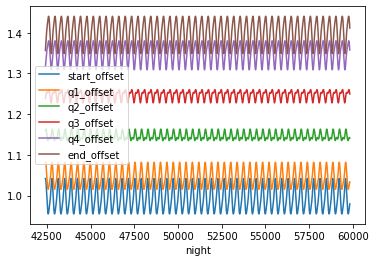

In [6]:
night_events.set_index('night')[['start_offset', 'q1_offset', 'q2_offset', 'q3_offset', 'q4_offset', 'end_offset']].plot()